# **0. 필요한 library import**

이번 dataset은 cifar-100 이기 때문에 torchvision 에 저장된 dataset을 불러와서 사용할 것이기 때문에 필요한 library들을 import 했다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# **1. 초기 설정**

이 코드는 PyTorch를 사용하여 CIFAR-100 데이터셋을 로드하고, 모델 학습을 위한 환경을 설정하는 과정으로 torch.cuda.is_available()을 확인하여 GPU(CUDA) 또는 CPU를 선택하고, torchvision.datasets.CIFAR100을 이용해 데이터를 다운로드 및 변환(크기 조정, 정규화)한 후, DataLoader로 배치 크기 128의 미니배치를 생성한다. 또한, 생성 모델(GAN 등)에서 사용할 노이즈 벡터 크기(100)와 CIFAR-100의 클래스 개수(100)를 정의하고, 합성곱(Conv) 및 배치 정규화(BatchNorm) 레이어의 가중치를 정규분포를 따라 초기화하는 함수 weights_init을 설정하는데, 이 설정은 보통 GAN(Generative Adversarial Network) 같은 생성 모델을 훈련할 때 사용된다.

In [ ]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# CIFAR100 데이터 로딩
dataset = dsets.CIFAR100(root='./data', download=True,
                         transform=transforms.Compose([
                             transforms.Resize(32),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                         ]))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

nz = 100
num_classes = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


Files already downloaded and verified


# **2. 모델 설정**

이 코드는 일반 GAN과 Conditional GAN(CGAN)의 생성자(Generator)와 판별자(Discriminator)를 정의하고 학습을 위한 설정을 완료하는 과정이다. Generator는 ConvTranspose2d(전치 합성곱) 연산을 이용해 노이즈를 32x32 RGB 이미지로 변환하고, Discriminator는 합성곱 신경망(CNN) 기반으로 입력 이미지가 진짜인지 판별한다. CGAN에서는 nn.Embedding을 활용해 클래스 레이블을 추가 정보로 활용하며, ConditionalDiscriminator는 이미지와 레이블을 채널 차원에서 결합하여 판별하는 구조다. 이후, 모델을 GPU로 이동시키고(.to(device)), 가중치를 초기화(weights_init)하며, BCELoss(이진 교차 엔트로피 손실)를 사용해 학습 손실을 계산하고, Adam 옵티마이저를 설정해 학습할 준비를 마쳐. 학습은 50 에포크 동안 진행될 예정이다!

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

In [ ]:
class CGAN_Generator(nn.Module):
    def __init__(self):
        super(CGAN_Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)
        self.model = Generator()

    def forward(self, z, label):
        label_embedding = self.label_emb(label).unsqueeze(2).unsqueeze(3)
        input = torch.mul(z, label_embedding)
        return self.model(input)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, label):
        label_embedding = self.label_emb(label).unsqueeze(2).unsqueeze(3).repeat(1, 1, x.size(2), x.size(3))
        input = torch.cat([x, label_embedding], dim=1)
        return self.model(input).view(-1)

G = Generator().to(device).apply(weights_init)
D = Discriminator().to(device).apply(weights_init)
G_c = CGAN_Generator().to(device).apply(weights_init)
D_c = ConditionalDiscriminator(num_classes).to(device).apply(weights_init)

criterion = nn.BCELoss()
optimizerD_GAN = optim.Adam(D.parameters(), lr=0.0002)
optimizerG_GAN = optim.Adam(G.parameters(), lr=0.0002)
optimizerD_CGAN = optim.Adam(D_c.parameters(), lr=0.0002)
optimizerG_CGAN = optim.Adam(G_c.parameters(), lr=0.0002)

# 학습 루프
epochs = 50

# **3. 학습하기**

이 코드는 GAN과 CGAN을 동시에 학습하는 과정을 구현한 것으로 먼저, dataloader에서 CIFAR-100의 이미지와 레이블을 불러온 후, 각 배치에 대해 GAN과 CGAN의 판별자(Discriminator)와 생성자(Generator)를 번갈아 학습시킨다. GAN 학습에서는 생성자 G가 랜덤 노이즈를 입력받아 가짜 이미지를 생성하고, 판별자 D는 실제 이미지와 가짜 이미지를 구분하는 역할을 한다. 판별자는 실제 이미지를 입력받으면 1(진짜)로, 가짜 이미지를 입력받으면 0(가짜)로 예측하도록 학습하고, 생성자는 판별자를 속여 가짜 이미지를 진짜처럼 보이도록 학습한다. 각각의 손실을 BCE(Binary Cross Entropy) Loss로 계산하고, Adam 옵티마이저를 사용해 가중치를 업데이트한다.

CGAN 학습에서는 GAN과 유사하지만, 생성자 G_c와 판별자 D_c가 클래스 레이블 정보를 추가적으로 활용하는 차이가 있다. G_c는 랜덤 노이즈와 함께 특정 클래스의 레이블을 입력받아 해당 클래스의 가짜 이미지를 생성하고, D_c는 이미지와 레이블을 함께 입력받아 진짜/가짜를 판별한다. 판별자는 실제 데이터와 레이블이 짝을 이루면 1(진짜), 가짜 데이터와 레이블이 짝을 이루면 0(가짜)로 예측하도록 학습되며, 생성자는 판별자를 속여 가짜 데이터를 진짜처럼 보이게 만들도록 훈련된다.

In [ ]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(dataloader):
        batch_size = images.size(0)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        D.zero_grad()
        real_images = images.to(device)
        output = D(real_images)
        loss_real = criterion(output, real_labels)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = G(noise)
        output = D(fake_images.detach())
        loss_fake = criterion(output, fake_labels)

        loss_D_GAN = (loss_real + loss_fake) / 2
        loss_D_GAN.backward()
        optimizerD_GAN.step()

        G.zero_grad()
        output = D(fake_images)
        loss_G_GAN = criterion(output, real_labels)
        loss_G_GAN.backward()
        optimizerG_GAN.step()

        D_c.zero_grad()
        label_emb = labels.to(device)

        output = D_c(real_images, label_emb)
        loss_real_c = criterion(output, real_labels)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images_c = G_c(noise, label_emb)
        output = D_c(fake_images_c.detach(), label_emb)
        loss_fake_c = criterion(output, fake_labels)

        loss_D_CGAN = (loss_real_c + loss_fake_c) / 2
        loss_D_CGAN.backward()
        optimizerD_CGAN.step()

        G_c.zero_grad()
        output = D_c(fake_images_c, label_emb)
        loss_G_CGAN = criterion(output, real_labels)
        loss_G_CGAN.backward()
        optimizerG_CGAN.step()

    print(f"Epoch [{epoch+1}/{epochs}] | GAN Loss D: {loss_D_GAN.item():.4f} | GAN Loss G: {loss_G_GAN.item():.4f} | CGAN Loss D: {loss_D_CGAN.item():.4f} | CGAN Loss G: {loss_G_CGAN.item():.4f}")

Epoch [1/50] | GAN Loss D: 0.0237 | GAN Loss G: 6.2751 | CGAN Loss D: 0.0834 | CGAN Loss G: 2.9788
Epoch [2/50] | GAN Loss D: 0.0077 | GAN Loss G: 6.9643 | CGAN Loss D: 0.2378 | CGAN Loss G: 1.8079
Epoch [3/50] | GAN Loss D: 0.0228 | GAN Loss G: 8.4066 | CGAN Loss D: 0.3451 | CGAN Loss G: 2.3149
Epoch [4/50] | GAN Loss D: 0.0035 | GAN Loss G: 7.5532 | CGAN Loss D: 0.4971 | CGAN Loss G: 0.8850
Epoch [5/50] | GAN Loss D: 0.0060 | GAN Loss G: 10.0809 | CGAN Loss D: 2.4695 | CGAN Loss G: 7.0333
Epoch [6/50] | GAN Loss D: 0.0033 | GAN Loss G: 10.4914 | CGAN Loss D: 0.1846 | CGAN Loss G: 2.5358
Epoch [7/50] | GAN Loss D: 0.0130 | GAN Loss G: 7.6993 | CGAN Loss D: 0.0863 | CGAN Loss G: 2.6034
Epoch [8/50] | GAN Loss D: 0.0193 | GAN Loss G: 5.5524 | CGAN Loss D: 0.9611 | CGAN Loss G: 1.9010
Epoch [9/50] | GAN Loss D: 0.0258 | GAN Loss G: 5.4258 | CGAN Loss D: 0.3424 | CGAN Loss G: 1.4058
Epoch [10/50] | GAN Loss D: 0.0024 | GAN Loss G: 10.5032 | CGAN Loss D: 0.2842 | CGAN Loss G: 2.2597
Epoch 

# **4. 학습 결과 생성하기**

이 코드는 GAN과 CGAN을 이용해 새로운 이미지를 생성하고 시각화하는 함수들을 정의한것으로, generate_gan_images(G, num_images=5) 함수는 학습된 GAN 생성자 G를 사용해 랜덤 노이즈에서 이미지를 생성하고, generate_cgan_images(G_c, class_idx, num_images=5) 함수는 CGAN 생성자 G_c를 이용해 특정 클래스(class_idx)의 이미지를 생성한다. 두 함수 모두 평가 모드(eval())로 전환한 후, 랜덤 노이즈를 입력받아 가짜 이미지를 생성하고, [-1, 1] 범위로 정규화된 출력을 [0, 1]로 변환한 뒤, matplotlib을 사용해 이미지를 출력한다. GAN은 무작위 이미지를 생성하지만, CGAN은 특정 클래스(class_idx)에 해당하는 이미지를 생성할 수 있는 특징이 있다. 마지막으로, generate_gan_images(G, num_images=5)를 호출해 일반 GAN 이미지를 생성하고, generate_cgan_images(G_c, class_idx=3, num_images=5)를 호출해 CIFAR-100에서 지정한 클래스의 가짜 이미지를 생성해 출력하는 것이다!

Generating images using GAN...


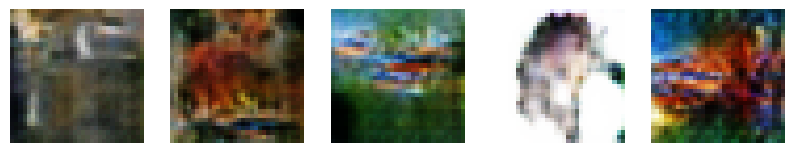

Generating images using CGAN for class 3...


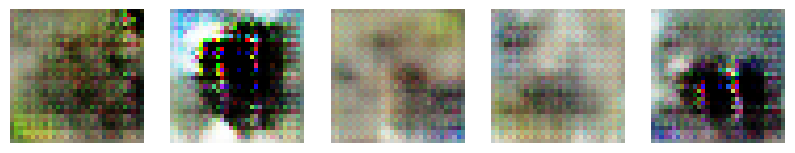

In [ ]:
def generate_gan_images(G, num_images=5):
    G.eval()  # 평가 모드
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = G(noise).cpu().numpy()

    fake_images = (fake_images + 1) / 2  # [-1, 1] → [0, 1]
    fake_images = np.transpose(fake_images, (0, 2, 3, 1))  # (C, H, W) → (H, W, C)

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(fake_images[i])
        axes[i].axis('off')
    plt.show()

def generate_cgan_images(G_c, class_idx, num_images=5):
    G_c.eval()  # 평가 모드
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    labels = torch.tensor([class_idx] * num_images, device=device)

    with torch.no_grad():
        fake_images = G_c(noise, labels).cpu().numpy()

    fake_images = (fake_images + 1) / 2  # [-1, 1] → [0, 1]
    fake_images = np.transpose(fake_images, (0, 2, 3, 1))  # (C, H, W) → (H, W, C)

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(fake_images[i])
        axes[i].axis('off')
    plt.show()

print("Generating images using GAN...")
generate_gan_images(G, num_images=5)

target_class = 3  \
print(f"Generating images using CGAN for class {target_class}...")
generate_cgan_images(G_c, class_idx=target_class, num_images=5)


# **5. 결과 분석**

GAN의 결과 분석

저번 딥러닝 기초 수업에서도 GAN을 이용한 이미지 생성을 실행했었는데, 잘 생성이 되지 않았었다. 아마 그 이유는 Colab에서 돌릴 수 있는 epoch의 한계 때문이지 않을까 생각한다. 그래도 일단 생성 이미지에 대해서 보자면, 1, 2, 3, 4, 5 모두 해상도는 떨어지지만, 얼추 형태가 보이는 무언가를 만들어낸 것을 볼 수 있다. 2번의 경우, 부엉이와 비슷한 무언가인 것 같고, 1번은 해달과 같은 무언가를 나타낸 것 같다. 모든 결과가 얼추 추정할 수 있을 정도의 모습으로 나온 것 같다.

CGAN의 결과 분석

CGAN의 3번 index는 비버이다. 이미지들을 살펴보면, 2, 5번은 노이즈가 많아 잘 보이지 않지만, 3, 4번을 보면, 얼추 비버라고 생각될 정도의 얼굴 모습을 잡아낸 것을 볼 수 있다. CGAN의 결과가 GAN보다 상대적으로 더 나은 형태를 보이며, 특정 클래스에 대한 구조를 더욱 명확하게 표현하고 있음을 확인할 수 있다. 이는 CGAN이 레이블 정보를 추가로 제공받아 학습하기 때문에, 보다 정교한 이미지 생성을 수행할 수 있기 때문으로 보인다.

특히, GAN과 비교했을 때 CGAN은 생성된 이미지에서 클래스의 특징이 보다 뚜렷하게 나타나는 경향을 보였다. 하지만 여전히 일부 이미지에서는 노이즈가 심하게 발생하거나, 형태가 흐릿하게 보이는 한계점이 존재했다. 이는 데이터셋의 복잡도, 모델 구조, 학습 epoch 수 등의 영향을 받은 결과로 보인다.

비교 및 결론

GAN과 CGAN을 비교해 보면, CGAN이 클래스 정보를 활용하여 보다 명확한 특징을 잡아낼 수 있는 장점이 있지만, 완벽한 품질의 이미지를 생성하는 데에는 여전히 부족함이 있었다. 특히, 학습 시간이 제한된 환경에서는 더욱 이러한 한계가 두드러졌다.

추후 개선을 위해 고려할 수 있는 점들은 다음과 같다:

- Epoch 증가: 충분한 학습을 통해 보다 정교한 결과를 도출할 수 있음

- 데이터 증강: 학습 데이터의 다양성을 높여 모델이 더 나은 일반화 성능을 갖도록 유도

- 모델 구조 개선: ResNet 기반의 발전된 생성 모델을 활용하여 품질 개선

- 고해상도 이미지 생성: Progressive GAN과 같은 기법을 적용하여 이미지 해상도를 높이는 방법 고려

이러한 개선을 통해 보다 현실적인 이미지를 생성할 수 있을 것으로 기대된다.

논문과 다른점

gan의 원 저자는 generator를 만들 때, MLP 만을 사용한 것으로 알고 있다. 하지만, 과제 자체가 CNN을 사용하라는 명시가 있었기 때문에 이를 고려해서 모델을 구성하였다.

